
# Task Submission: Predict Daily Global Confirmed Cases

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# 1. Import Libraries and input data

In [2]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import requests
import numpy as np
import pandas as pd
import io

BASE_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = 'time_series_covid19_confirmed_global.csv'
DEATH = 'time_series_covid19_deaths_global.csv'
RECOVERED = 'time_series_covid19_recovered_global.csv'
CONFIRMED_US = 'time_series_covid19_confirmed_US.csv'
DEATH_US = 'time_series_covid19_deaths_US.csv'

def get_covid_data(subset = 'CONFIRMED'):
    """This function returns the latest available data subset of COVID-19. 
        The returned value is in pandas DataFrame type.
    Args:
        subset (:obj:`str`, optional): Any value out of 5 subsets of 'CONFIRMED',
        'DEATH', 'RECOVERED', 'CONFIRMED_US' and 'DEATH_US' is a valid input. If the value
        is not chosen or typed wrongly, CONFIRMED subet will be returned.
    """    

    if subset.upper() == 'DEATH':
        CSV_URL = BASE_URL + DEATH
    elif subset.upper() == 'RECOVERED':
        CSV_URL = BASE_URL + RECOVERED        
    elif subset.upper() == 'CONFIRMED_US':
        CSV_URL = BASE_URL + CONFIRMED_US        
    elif subset.upper() == 'DEATH_US':
        CSV_URL = BASE_URL + DEATH_US        
    else:
        CSV_URL = BASE_URL + CONFIRMED

    with requests.Session() as s:
        download = s.get(CSV_URL)
        decoded_content = download.content.decode('utf-8')
        data = pd.read_csv(io.StringIO(decoded_content))

    return data

In [4]:
df_train_confirmed = get_covid_data(subset = 'CONFIRMED')
df_train_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,1092
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,609
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,717
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,24


In [5]:
# We will fill the missing states with a value 'NoState'
df_train_confirmed=df_train_confirmed.fillna('NoState')
# changing the data type
df_train_confirmed.head()
#train=train.rename(columns={ConfirmedCases:'Confirmed','Country_Region':'Country/Region',
                    # 'Province_State':'Province/State','Date':'ObservationDate'})
#num_cols=['Confirmed']
#for col in num_cols:
#    temp=[int(i) for i in train[col]]
#    train[col]=temp 
#train.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,NoState,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,607,665,714,784,840,906,933,996,1026,1092
1,NoState,Albania,41.1533,20.1683,0,0,0,0,0,0,...,446,467,475,494,518,539,548,562,584,609
2,NoState,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811
3,NoState,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,638,646,659,673,673,696,704,713,717,717
4,NoState,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,24,24,24,24


In [6]:
#countries=['India','Italy','Spain']

#y=df_train_confirmed.loc[df_train_confirmed['Country/Region']=='Brazil'].iloc[0,4:]
#s = pd.DataFrame({'Brazil':y})
#for c in countries:    
    #pyplot.plot(range(y.shape[0]),y,'r--')
#    s[c] = df_train_confirmed.loc[df_train_confirmed['Country/Region']==c].iloc[0,4:]
#pyplot.plot(range(y.shape[0]),y,'g-')
#plt.plot(range(y.shape[0]), s)
#plt.legend(countries)

#s.tail(5)



# 2. Prediction using Prophet

In [7]:
df_usa1 = df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "US"]
df_spain=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "Spain"]
df_india=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "India"]
df_brazil=df_train_confirmed.loc[df_train_confirmed["Country/Region"]== "Brazil"]

In [8]:
dates1=df_train_confirmed[4:]
temp_usa = df_usa1.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_usa = temp_usa.groupby('Date')['Confirmed'].sum().reset_index()

pr_usa = pd.DataFrame(temp_usa)

pr_usa.columns = ['ds','y']
pr_usa.drop(pr_usa.tail(4).index,inplace=True)

#Spain
temp_spain = df_spain.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_spain = temp_spain.groupby('Date')['Confirmed'].sum().reset_index()

pr_spain = pd.DataFrame(temp_spain)

pr_spain.columns = ['ds','y']
pr_spain.drop(pr_spain.tail(4).index,inplace=True)

#India
temp_india = df_india.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_india = temp_india.groupby('Date')['Confirmed'].sum().reset_index()

pr_india = pd.DataFrame(temp_india)

pr_india.columns = ['ds','y']
pr_india.drop(pr_india.tail(4).index,inplace=True)

#Brazil
temp_brazil = df_brazil.melt(value_vars=dates1, var_name='Date', value_name='Confirmed')
temp_brazil = temp_brazil.groupby('Date')['Confirmed'].sum().reset_index()

pr_brazil = pd.DataFrame(temp_brazil)

pr_brazil.columns = ['ds','y']
pr_brazil.drop(pr_brazil.tail(4).index,inplace=True)


In [9]:
import fbprophet
#USA
m=fbprophet.Prophet()
m.fit(pr_usa)
future=m.make_future_dataframe(periods=10)
forecast_usa=m.predict(future)
forecast_usa.tail(11)

#Spain
m=fbprophet.Prophet()
m.fit(pr_spain)
future=m.make_future_dataframe(periods=10)
forecast_spain=m.predict(future)
forecast_spain.tail(11)

#India

m=fbprophet.Prophet()
m.fit(pr_india)
future=m.make_future_dataframe(periods=10)
forecast_india=m.predict(future)
forecast_india.tail(11)

#Brazil
m=fbprophet.Prophet()
m.fit(pr_brazil)
future=m.make_future_dataframe(periods=10)
forecast_brazil=m.predict(future)
forecast_brazil.tail(11)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
90,2020-04-21,40356.559524,39394.837859,41352.455980,40356.559524,40356.559524,-14.195974,-14.195974,-14.195974,-14.195974,-14.195974,-14.195974,0.0,0.0,0.0,40342.363549
91,2020-04-22,42166.321166,41175.549244,43035.469422,42160.557879,42172.925926,-50.941166,-50.941166,-50.941166,-50.941166,-50.941166,-50.941166,0.0,0.0,0.0,42115.380000
92,2020-04-23,43976.082809,43012.630836,44962.206865,43918.596373,44030.050042,59.541354,59.541354,59.541354,59.541354,59.541354,59.541354,0.0,0.0,0.0,44035.624162
93,2020-04-24,45785.844451,44930.488164,46846.744679,45656.301311,45939.598031,80.603026,80.603026,80.603026,80.603026,80.603026,80.603026,0.0,0.0,0.0,45866.447478
94,2020-04-25,47595.606094,46710.969876,48730.541582,47374.297802,47836.663813,65.835647,65.835647,65.835647,65.835647,65.835647,65.835647,0.0,0.0,0.0,47661.441741
95,2020-04-26,49405.367737,48314.811198,50595.993742,49067.470591,49760.380312,-24.386505,-24.386505,-24.386505,-24.386505,-24.386505,-24.386505,0.0,0.0,0.0,49380.981231
96,2020-04-27,51215.129379,49986.617077,52231.250923,50753.381668,51689.554797,-116.456381,-116.456381,-116.456381,-116.456381,-116.456381,-116.456381,0.0,0.0,0.0,51098.672998
97,2020-04-28,53024.891022,51861.857174,54136.197968,52416.765566,53636.689938,-14.195974,-14.195974,-14.195974,-14.195974,-14.195974,-14.195974,0.0,0.0,0.0,53010.695048
98,2020-04-29,54834.652665,53548.930595,56059.266122,54069.125515,55590.222928,-50.941166,-50.941166,-50.941166,-50.941166,-50.941166,-50.941166,0.0,0.0,0.0,54783.711498
99,2020-04-30,56644.414307,55291.531918,58029.265431,55691.366880,57567.031152,59.541354,59.541354,59.541354,59.541354,59.541354,59.541354,0.0,0.0,0.0,56703.955661


In [10]:
cnfrm = forecast_usa.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm_prophet_usa']
prophet_data_usa=cnfrm.tail(10)
prophet_data_usa
#Spain
cnfrm = forecast_spain.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm_prophet_spain']
prophet_data_spain=cnfrm.tail(10)
prophet_data_spain
#India
cnfrm = forecast_india.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm_prophet_india']
prophet_data_india=cnfrm.tail(10)
prophet_data_india
#Brazil
cnfrm = forecast_brazil.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm_prophet_brazil']
prophet_data_brazil=cnfrm.tail(10)
prophet_data_brazil


,Date,Confirm_prophet_brazil
91,2020-04-22,42166.321166
92,2020-04-23,43976.082809
93,2020-04-24,45785.844451
94,2020-04-25,47595.606094
95,2020-04-26,49405.367737
96,2020-04-27,51215.129379
97,2020-04-28,53024.891022
98,2020-04-29,54834.652665
99,2020-04-30,56644.414307
100,2020-05-01,58454.175950


# 3. Predictions using LSTM

In [11]:
df_usa1 = df_usa1.iloc[:, 5:]
df_spain= df_spain.iloc[:,5:]
df_india = df_india.iloc[:, 5:]
df_brazil= df_brazil.iloc[:,5:]


In [12]:
#Predicting future cases of USA using LSTM network
daily_cases = df_usa1.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_usa = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases_usa = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 4.11820125579834 test loss: 39.986717224121094
Epoch 100 train loss: 0.7557547688484192 test loss: 408.22039794921875
Epoch 200 train loss: 0.7304542064666748 test loss: 370.7748107910156
Epoch 300 train loss: 0.6867979764938354 test loss: 321.7075500488281
Epoch 400 train loss: 0.6013849973678589 test loss: 224.47271728515625


In [13]:
#Predicting future cases of spain using LSTM network
daily_cases = df_spain.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_spain = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases_spain = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 5.733306884765625 test loss: 19.323162078857422
Epoch 100 train loss: 0.8968130946159363 test loss: 297.61639404296875
Epoch 200 train loss: 0.8802835941314697 test loss: 270.3199157714844
Epoch 300 train loss: 0.8076767921447754 test loss: 135.82383728027344
Epoch 400 train loss: 0.7358153462409973 test loss: 63.43352508544922


In [14]:
#Predicting future cases of India using LSTM network
daily_cases = df_india.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_india = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases_india = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 2.4948737621307373 test loss: 141.32769775390625
Epoch 100 train loss: 0.5635966658592224 test loss: 379.2938232421875
Epoch 200 train loss: 0.5305070281028748 test loss: 235.46810913085938
Epoch 300 train loss: 0.4868062138557434 test loss: 201.4397430419922
Epoch 400 train loss: 0.4891468286514282 test loss: 164.39492797851562


In [15]:
#Predicting future cases of Brazil using LSTM network
daily_cases = df_brazil.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.tail()
#we take 20% of total data for validation and rest for testing i.e;(as of now 80 days first 64 days for testing and 16 days for validation)
test_data_size = 16

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
#Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

#Create a sequence
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

import torch
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

import torch.nn as nn
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 500   # if its time consuming then set it to 500 or 100
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 100 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 100 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

#Training the model
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    
true_cases_brazil = scaler.inverse_transform(
np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases_brazil = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

Epoch 0 train loss: 3.8558197021484375 test loss: 78.2811279296875
Epoch 100 train loss: 0.6768089532852173 test loss: 294.227783203125
Epoch 200 train loss: 0.5831965804100037 test loss: 305.5193176269531
Epoch 300 train loss: 0.5947656035423279 test loss: 250.67189025878906
Epoch 400 train loss: 0.5919476747512817 test loss: 217.02833557128906


In [16]:
prophet_data_usa.insert(2,'LSTM_usa',predicted_cases_usa)
prophet_data_spain.insert(2,'LSTM_spain',predicted_cases_spain)
prophet_data_india.insert(2,'LSTM_india',predicted_cases_india)
prophet_data_brazil.insert(2,'LSTM_brazil',predicted_cases_brazil)

In [17]:
USA_data=pd.DataFrame(prophet_data_usa)
USA_data['FutureDates']=USA_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

Spain_data=pd.DataFrame(prophet_data_spain)
Spain_data['FutureDates']=Spain_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

India_data=pd.DataFrame(prophet_data_india)
India_data['FutureDates']=India_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

Brazil_data=pd.DataFrame(prophet_data_brazil)
Brazil_data['FutureDates']=Brazil_data['Date'].apply(lambda x: x.strftime('%d%m%Y'))

# 4 . Plotting future predicted data

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. U

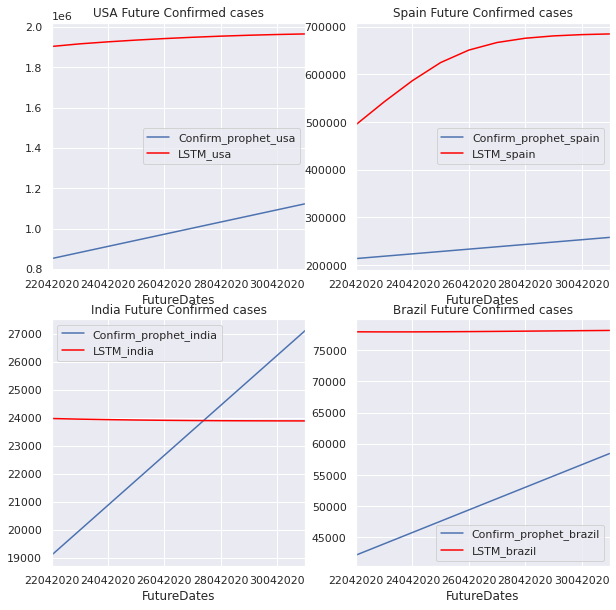

In [18]:

fig, axes = plt.subplots(nrows=2, ncols=2)

USA_data.plot(kind='line',x='FutureDates',y='Confirm_prophet_usa',ax=axes[0,0],figsize=(10,10))
USA_data.plot(kind='line',x= 'FutureDates',y='LSTM_usa', color='red', ax=axes[0,0])
axes[0, 0].set_title('USA Future Confirmed cases')

Spain_data.plot(kind='line',x='FutureDates',y='Confirm_prophet_spain',ax=axes[0,1],figsize=(10,10))
Spain_data.plot(kind='line',x= 'FutureDates',y='LSTM_spain', color='red', ax=axes[0,1])
axes[0, 1].set_title('Spain Future Confirmed cases')

India_data.plot(kind='line',x='FutureDates',y='Confirm_prophet_india',ax=axes[1,0],figsize=(10,10))
India_data.plot(kind='line',x= 'FutureDates',y='LSTM_india', color='red', ax=axes[1,0])
axes[1, 0].set_title('India Future Confirmed cases')

Brazil_data.plot(kind='line',x='FutureDates',y='Confirm_prophet_brazil',ax=axes[1,1],figsize=(10,10))
Brazil_data.plot(kind='line',x= 'FutureDates',y='LSTM_brazil', color='red', ax=axes[1,1])
axes[1, 1].set_title('Brazil Future Confirmed cases')

plt.show()